In [1]:
import pandas as pd
import numpy as np
import os
import pathlib
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import RMSprop


GTZAN dataset consists of 10 genres

Blues
Classical
Country
Disco
Hiphop
Jazz
Metal
Pop
Reggae
Rock
Each genre contains 100 songs. Total dataset: 1000 songs

We will only be using the spectrogram png files for this prototype

In [2]:
#uncomment and run this cell this if you, like me, uploaded the data files to g-drive
'''
from google.colab import drive
drive.mount('/content/drive')
'''

Mounted at /content/drive


First, we need to retrieve the spectrogram files and convert them into a format readable by keras. Depending on how tempermental g-drive is, this could take a while

Confirm that the folder hierarchy looks like:


*   Genre 1
  *   Image File
  *   Image File
  *   Image File
  *   ...


*   Genre 2
  *   Image File
  *   Image File
  *   Image File
  *   ...






In [3]:
import os
from PIL import Image

#change this line to whatever directory the GTZAN spectogram images are located
rootdir = '/content/drive/My Drive/Data/images_original'

#using python list data structure temporarily for efficiency and utility
labels = []
images = []

# iterating through each genre folder, append that folder name to the labels list, 
# then we converty the png into a numpy array and append that to images.
# for somereason this process extracts 4 color layers when there should only be 3.
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        labels.append(os.path.basename(subdir))
        img = Image.open(os.path.join(subdir, file))
        images.append(np.array(img))

In [4]:
labels[::100]

['metal',
 'hiphop',
 'country',
 'jazz',
 'pop',
 'disco',
 'blues',
 'classical',
 'reggae',
 'rock']

In [5]:
#converting our python lists to numpy arrays
labels = np.array(labels)
images = np.array(images)

Now we need to encode the labels to ints in alphabetacal order so we can use keras.utils.to_categorical later.


In [6]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock'])
labels = le.transform(labels)



In [7]:
labels[::100]

array([6, 4, 2, 5, 7, 3, 0, 1, 8, 9])

Leveraging sklearn's library for creating a train test split of our two numpy arrays. I currently have a 80-20 split for train-test. Eventually we will wank to implement k-fold cross validation.



In [8]:
from sklearn.model_selection import train_test_split

train_labels, test_labels, train_images, test_images = train_test_split(labels, images, test_size = .2, random_state = 42)

In [9]:
# 4 color chanels. idk.
train_images.shape

(799, 288, 432, 4)

In [10]:
#this cell is a version-protection process i found online to check sure that the 
#(color) channel data should be first or last dimension in out tensor
from tensorflow.keras import backend as K

if K.image_data_format() == 'channels_first':
    train_images = train_images.reshape(train_images.shape[0], 4, 432, 288)
    test_images = test_images.reshape(test_images.shape[0], 4, 432, 288)
    input_shape = (4, 432, 288)
else:
    train_images = train_images.reshape(train_images.shape[0], 432, 288, 4)
    test_images = test_images.reshape(test_images.shape[0], 432, 288, 4)
    input_shape = (432, 288, 4)
    
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')
train_images /= 255
test_images /= 255

Now we do the keras equivalent of one-how-encoding and convert our labels to catigorical martixes using to_categorical


In [11]:
train_labels = tensorflow.keras.utils.to_categorical(train_labels, 10)
test_labels = tensorflow.keras.utils.to_categorical(test_labels, 10)

double check and make sure our input data look like it should....

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


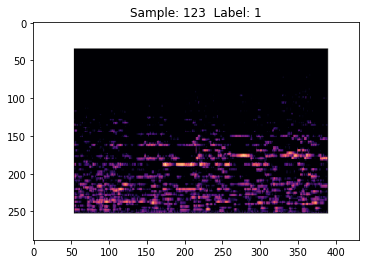

In [12]:
import matplotlib.pyplot as plt

def display_sample(num):
    #Print the one-hot array of this sample's label 
    print(train_labels[num])  
    #Print the label converted back to a number
    label = train_labels[num].argmax(axis=0)
    #Reshape the lots of values to a 423x288 image
    image = train_images[num].reshape([288, 432, 4])
    plt.title('Sample: %d  Label: %d' % (num, label))
    plt.imshow(image, cmap=plt.get_cmap('gray_r'))
    plt.show()
    
display_sample(123)

Model time...

CNNs have so many layers... Some things I have tried so far:


*   Added additional dense layers for deeper learning
*   Added additional Conv2d layers for deeper convolution (I think this is a variable we will really need to dial in for consistant results)
*   increase the pool_size of the Max Pooling layer



In [13]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
# 64 3x3 kernels
model.add(Conv2D(64, (3, 3), activation='relu'))
# Reduce by taking the max of each 2x2 block, I see this in most SNN models, but
#believe it just speeds up training a bit. 
model.add(MaxPooling2D(pool_size=(2, 2)))
# Dropout to avoid overfitting
model.add(Dropout(0.1))
# Flatten the results to one dimension for passing into our final layer
model.add(Flatten())
# A hidden layer to learn with
model.add(Dense(128, activation='relu'))
# Another dropout
model.add(Dropout(0.25))
# Final categorization from 0-9 with softmax
model.add(Dense(10, activation='softmax'))

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 430, 286, 32)      1184      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 428, 284, 64)      18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 214, 142, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 214, 142, 64)      0         
_________________________________________________________________
flatten (Flatten)            (None, 1944832)           0         
_________________________________________________________________
dense (Dense)                (None, 128)               248938624 
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

The rest is mosly boilerplate from keras and tensorflow documentation sites.

In [15]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

#Hold up.
This is going to take a LOOOONG time without CUDA support. Potentially multiple hours. If you have a nvidia GPU on your machine, make sure that you have a GPU enabled runtime. In google collab this is done by toolbar > runtime > change runtime type > GPU.

In [16]:
history = model.fit(train_images, train_labels,
                    batch_size=32,
                    epochs=20,
                    verbose=2,
                    validation_data=(test_images, test_labels))

Epoch 1/20
25/25 - 8s - loss: 42.9460 - accuracy: 0.1139 - val_loss: 2.3020 - val_accuracy: 0.1600
Epoch 2/20
25/25 - 7s - loss: 2.3027 - accuracy: 0.1001 - val_loss: 2.3028 - val_accuracy: 0.1050
Epoch 3/20
25/25 - 7s - loss: 2.3025 - accuracy: 0.0989 - val_loss: 2.3033 - val_accuracy: 0.1150
Epoch 4/20
25/25 - 7s - loss: 2.3009 - accuracy: 0.1314 - val_loss: 2.2941 - val_accuracy: 0.1000
Epoch 5/20
25/25 - 7s - loss: 2.2564 - accuracy: 0.1552 - val_loss: 2.1572 - val_accuracy: 0.1850
Epoch 6/20
25/25 - 7s - loss: 1.9653 - accuracy: 0.3154 - val_loss: 2.0426 - val_accuracy: 0.2700
Epoch 7/20
25/25 - 7s - loss: 1.7435 - accuracy: 0.3780 - val_loss: 1.8340 - val_accuracy: 0.4050
Epoch 8/20
25/25 - 7s - loss: 1.5331 - accuracy: 0.4668 - val_loss: 1.7469 - val_accuracy: 0.3950
Epoch 9/20
25/25 - 8s - loss: 1.3701 - accuracy: 0.5369 - val_loss: 1.6726 - val_accuracy: 0.4450
Epoch 10/20
25/25 - 8s - loss: 1.1404 - accuracy: 0.6195 - val_loss: 1.5912 - val_accuracy: 0.4450
Epoch 11/20
25/25 

In [18]:
score = model.evaluate(test_images, test_labels, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.8854975700378418
Test accuracy: 0.47999998927116394


The results are.... inconsistant. I have seen accuracies from well below average (0.07) to pretty good (0.5). This leads me to believe that some hyperparameter tuning and a MUCH larger dataset would yield better accuracy. It is also possible CNNs are not the way to go and that we should shift our focus to feature extraction.